In [99]:
import numpy as np
import torch
import networkx as nx
import torch_geometric
from networkx.algorithms import bipartite

data = torch.load("data_object.pt")


G = torch_geometric.utils.to_networkx(data)
G = nx.to_undirected(G)
bipartite.is_bipartite(G)

True

In [278]:

nx.write_gexf(G, "SNA10K.gexf")

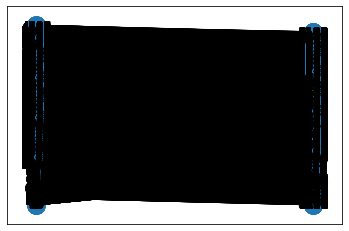

In [95]:
import matplotlib.pyplot as plt
edges = G.edges()

In [193]:
# split dataset
import random
random.seed(42)
edgelist = list(G.edges())
test_size = len(edgelist) // 10 # 20% of the dataset as val
max_non_edges = test_size # no. of non-edges in test split
test_edgelist = random.sample(edgelist, test_size) 
test_edgelist = [list(e) + [1] for e in test_edgelist]

train_G = G.copy()

# add non-edges to test set
X, Y = bipartite.sets(train_G)
X = list(X)
random.shuffle(X)
Y = list(Y)
random.shuffle(Y)
count = 0


for x in X:
    for y in Y:
        if not train_G.has_edge(x,y):
            test_edgelist.append([x,y,0])
            count += 1
        if count >= max_non_edges:
            break
    if count >= max_non_edges:
        break



# remove from original graph
train_G.remove_edges_from(test_edgelist)

In [167]:
print(len(test_edgelist))
train_G.number_of_edges()

23577


212202

In [168]:
import numpy as np
from numpy.linalg import inv

#Calculate highest eigenvector
L = nx.normalized_laplacian_matrix(G)
print("computed normalised_laplacian")
e = np.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))
beta = np.real(1/max(e))
I = np.identity(len(G.nodes)) #create identity matrix

#Katz score
katz = inv(I - nx.to_numpy_array(G)*beta) - I
katz = np.real(katz)
katz


computed normalised_laplacian


C:\Users\sidda\AppData\Roaming\Python\Python39\site-packages\scipy\sparse\_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


Largest eigenvalue: (2.000000000000028+0j)


array([[-0.71926009,  0.07347841,  0.16549998, ..., -0.14629738,
        -0.08521013,  0.03303376],
       [ 0.07347841, -0.85162493,  0.234125  , ..., -0.14824079,
         0.27850034, -0.01615939],
       [ 0.16549998,  0.234125  , -0.62690749, ..., -0.0529516 ,
        -0.07961314, -0.06396189],
       ...,
       [-0.14629738, -0.14824079, -0.0529516 , ..., -0.85700825,
        -0.07307708, -0.03450547],
       [-0.08521013,  0.27850034, -0.07961314, ..., -0.07307708,
         0.05955978,  0.10808677],
       [ 0.03303376, -0.01615939, -0.06396189, ..., -0.03450547,
         0.10808677, -1.32885464]])

In [ ]:
adamic =  list(nx.link_prediction.adamic_adar_index(G))



In [ ]:
retrunProbs = []

for edge in test_edgelist:
    retrunProbs.append(katz[edge[0]][edge[1]])


from sklearn.preprocessing import MinMaxScaler
minmaxScaler = MinMaxScaler()

retrunProbs = minmaxScaler.fit_transform(np.array(retrunProbs).reshape(-1,1))
retrunProbs
    

In [213]:
retrunProbs = []

for edge in test_edgelist:
    retrunProbs.append(katz[edge[0]][edge[1]])


from sklearn.preprocessing import MinMaxScaler
minmaxScaler = MinMaxScaler()

retrunProbs = minmaxScaler.fit_transform(np.array(retrunProbs).reshape(-1,1))
retrunProbs
    

array([[0.50175178],
       [0.46523181],
       [0.57529079],
       ...,
       [0.49280208],
       [0.55335609],
       [0.45491844]])

In [216]:

y_test = np.array(test_edgelist)[:, 2]

In [219]:
retrunProbs.shape

(47154, 1)

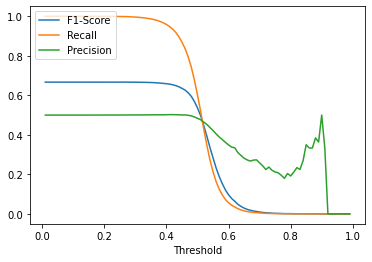

In [277]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
recall = []
prec = []
f1 = []
for thresh in np.arange(0.01, 1.0, 0.01):
    f1.append(f1_score(y_test, retrunProbs > thresh))
    recall.append(recall_score(y_test, retrunProbs > thresh))
    prec.append(precision_score(y_test, retrunProbs > thresh))

plt.plot(np.arange(0.01, 1.0, 0.01), f1, label="F1-Score")
plt.plot(np.arange(0.01, 1.0, 0.01), recall, label="Recall")
plt.plot(np.arange(0.01, 1.0, 0.01), prec, label="Precision")
plt.xlabel("Threshold")
plt.legend(loc="upper left")

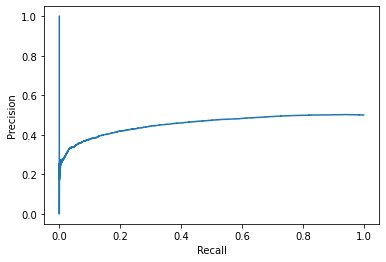

In [263]:
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(y_test, retrunProbs)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [273]:
print(f1.index(max(f1)))

26


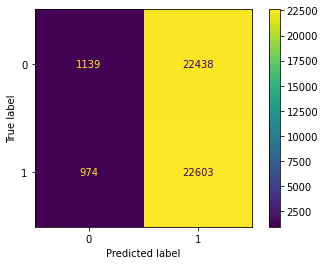

In [276]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, retrunProbs > 0.4)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()